In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(tf.__version__)

2.17.0


In [ ]:
pip install tensorflow==2.17.0

In [ ]:
# import os
# import random
# import shutil

# def split_data(source_dir, base_dir, train_size=0.8, val_size=0.1, test_size=0.1):
#     # Membuat folder utama untuk train, val, dan test
#     os.makedirs(base_dir, exist_ok=True)
#     train_dir = os.path.join(base_dir, 'train')
#     val_dir = os.path.join(base_dir, 'val')
#     test_dir = os.path.join(base_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     # Menentukan kategori (misalnya acne, non-acne)
#     categories = os.listdir(source_dir)

#     # Untuk setiap kategori, buat folder di train, val, test dan pindahkan gambar
#     for category in categories:
#         category_dir = os.path.join(source_dir, category)

#         # Pastikan folder kategori tidak kosong
#         if not os.path.exists(category_dir) or len(os.listdir(category_dir)) == 0:
#             continue

#         files = os.listdir(category_dir)

#         # Hanya pilih file dengan ekstensi yang valid
#         valid_extensions = ['.jpg', '.jpeg', '.png']
#         files = [f for f in files if os.path.splitext(f)[1].lower() in valid_extensions]

#         random.shuffle(files)

#         # Menghitung jumlah data untuk training, validation, dan testing
#         total_files = len(files)
#         train_count = int(train_size * total_files)
#         val_count = int(val_size * total_files)
#         test_count = total_files - train_count - val_count  # Sisanya untuk test

#         # Buat folder untuk kategori di setiap subset (train, val, test)
#         os.makedirs(os.path.join(train_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(val_dir, category), exist_ok=True)
#         os.makedirs(os.path.join(test_dir, category), exist_ok=True)

#         # Pindahkan file ke folder masing-masing
#         for i, file in enumerate(files):
#             source_file = os.path.join(category_dir, file)

#             if i < train_count:
#                 target_dir = os.path.join(train_dir, category)
#             elif i < train_count + val_count:
#                 target_dir = os.path.join(val_dir, category)
#             else:
#                 target_dir = os.path.join(test_dir, category)

#             shutil.copy(source_file, target_dir)

# # Tentukan direktori sumber dan tujuan
# source_dir = '/content/drive/MyDrive/BEAUSKIN ML/dataset jerawat'
# base_dir = '/content/drive/MyDrive/BEAUSKIN ML/tingkatjerawat'

# # Panggil fungsi untuk membagi dataset
# split_data(source_dir, base_dir)


In [ ]:
train_dir = '/content/drive/MyDrive/BEAUSKIN ML/tingkatan jerawat/train'
val_dir = '/content/drive/MyDrive/BEAUSKIN ML/tingkatan jerawat/val'
test_dir = '/content/drive/MyDrive/BEAUSKIN ML/tingkatan jerawat/test'

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow_from_directory(train_dir,
                                                  target_size=(128,128),
                                                  color_mode="rgb",
                                                  class_mode="categorical")

valid_generator = datagen.flow_from_directory(val_dir,
                                                    target_size=(128,128),
                                                    color_mode="rgb",
                                                    class_mode="categorical")

test_datagen = ImageDataGenerator(rescale =1./255)
test_generator = datagen.flow_from_directory(test_dir,
                                                   target_size=(128,128),
                                                   color_mode="rgb",
                                                   class_mode="categorical")

Found 2128 images belonging to 4 classes.
Found 423 images belonging to 4 classes.
Found 426 images belonging to 4 classes.


In [ ]:
# Mendapatkan label dari train_generator
class_labels = train_generator.class_indices
print("Class Labels:", class_labels)

Class Labels: {'Mild': 0, 'Moderate': 1, 'Normal': 2, 'Severe': 3}


In [ ]:
# Memuat MobileNetV2 tanpa lapisan atas (include_top=False) dan dengan bobot dari ImageNet
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# Memulai dengan input base model
x = base_model.output

# Tambahkan lapisan pooling global
x = GlobalAveragePooling2D()(x)

# Tambahkan lapisan Dense untuk klasifikasi
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(4, activation='softmax')(x)

# Membuat model akhir
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7
# # )
# callbacks=[reduce_lr],
history = model.fit(train_generator, validation_data=valid_generator, epochs=50)


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 338ms/step - accuracy: 0.8080 - loss: 0.4386 - val_accuracy: 0.7778 - val_loss: 0.5010
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 329ms/step - accuracy: 0.7826 - loss: 0.4611 - val_accuracy: 0.7565 - val_loss: 0.5142
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.8060 - loss: 0.4305 - val_accuracy: 0.7967 - val_loss: 0.4782
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 321ms/step - accuracy: 0.7914 - loss: 0.4526 - val_accuracy: 0.7943 - val_loss: 0.4713
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.8019 - loss: 0.4717 - val_accuracy: 0.7730 - val_loss: 0.4603
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 329ms/step - accuracy: 0.7864 - loss: 0.4885 - val_accuracy: 0.8085 - val_loss: 0.4458
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 325ms/step - accuracy: 0.8111 - loss: 0.4453 - val_accuracy: 0.7849 - val_loss: 0.4725
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 22s 322ms/step - accuracy: 0.8144 - loss: 0.4375 - val_accu

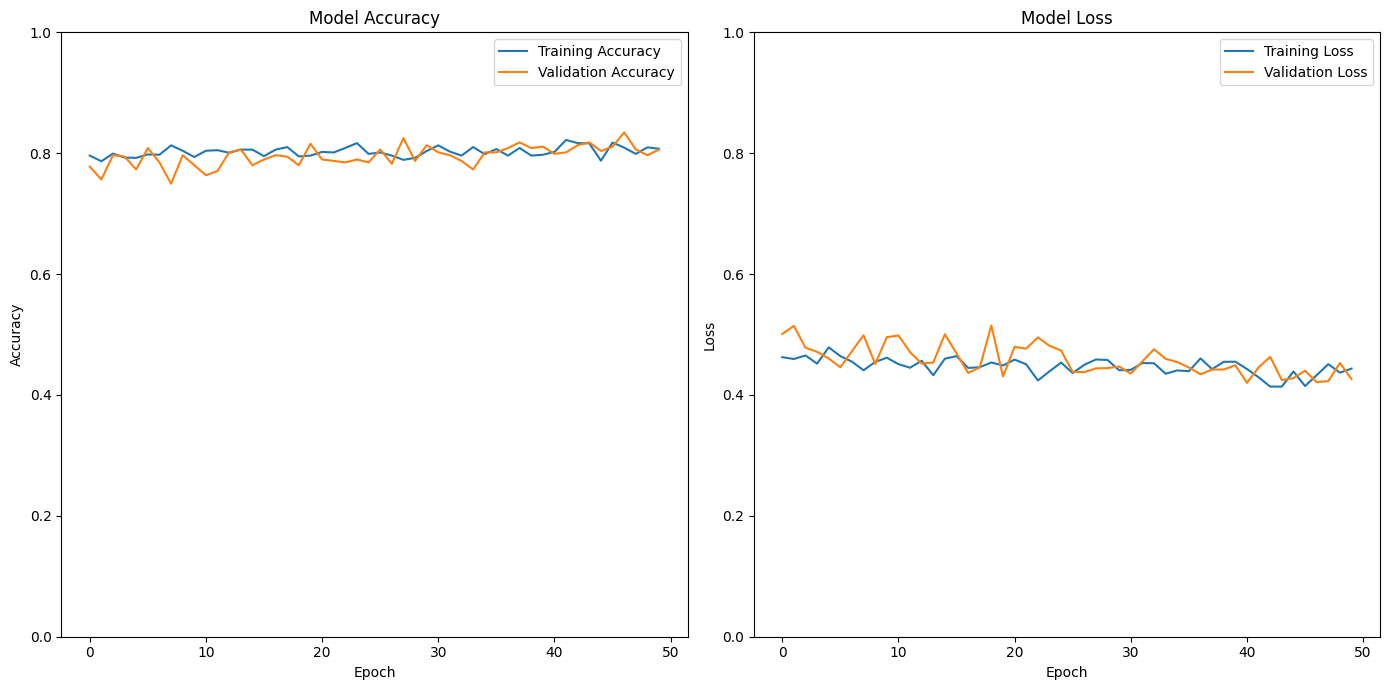

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training & validation accuracy values
plt.figure(figsize=(14, 7))  # Increase figure size for better clarity

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.ylim([0, 1])

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0, 1])

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.8124 - loss: 0.4489
Test Loss: 0.41590553522109985
Test Accuracy: 0.8221153616905212


In [ ]:
model.save('/content/drive/MyDrive/BEAUSKIN ML/models/acne_grade_model4.h5')

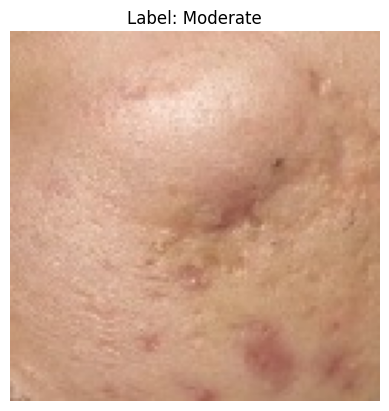

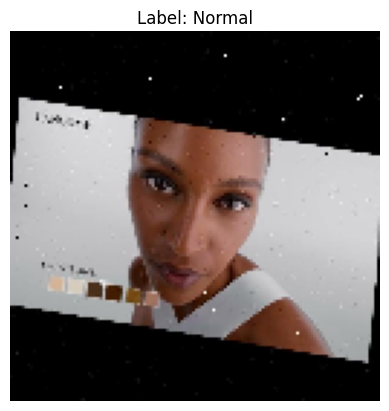

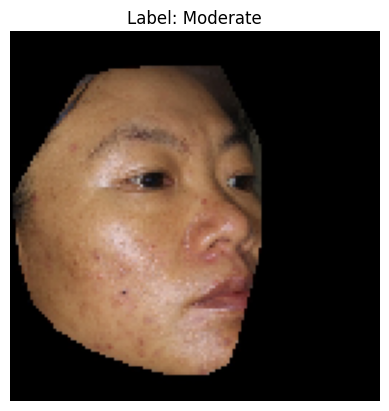

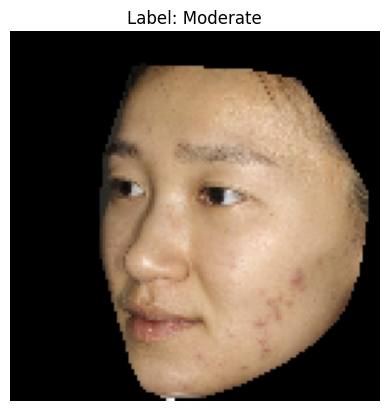

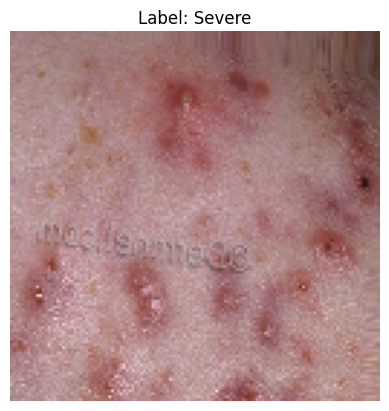

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


# Get the list of categories (subfolders)
categories = os.listdir(test_dir)

# Function to load and display a random image with its label
def load_and_display_random_image_with_label():
    # Randomly select a category (label)
    category = random.choice(categories)

    # Get the list of image files in the selected category
    category_path = os.path.join(test_dir, category)
    files = os.listdir(category_path)

    # Randomly select a file
    selected_file = random.choice(files)
    selected_image_path = os.path.join(category_path, selected_file)

    # Load and preprocess the image
    img = image.load_img(selected_image_path, target_size=(128, 128))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.title(f"Label: {category}")  # Display the label as title
    plt.show()

# Display two random images with their labels
for _ in range(5):
    load_and_display_random_image_with_label()
